## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG19
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_folder = 'split/train'
test_folder = 'split/test'
val_folder = 'split/validation'

In [3]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 5

## VGG19: Feature extraction

In [4]:
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [5]:
vgg19_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=5, class_mode='binary')
    print(generator)
    i=0
    for inputs_batch, labels_batch in generator:
        #print('i:',i,labels_batch)
        features_batch = vgg19_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        #print('\t',features.shape,' ',labels.shape)
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [7]:
# You should be able to divide sample_amount by batch_size
train_features, train_labels = extract_features(train_folder, 3410) 
train_features = np.reshape(train_features, (3410, 4 * 4 * 512))

Found 4685 images belonging to 2 classes.


In [8]:
validation_features, validation_labels = extract_features(val_folder, 420) 
validation_features = np.reshape(validation_features, (420, 4 * 4 * 512))

Found 792 images belonging to 2 classes.


In [9]:
test_features, test_labels = extract_features(test_folder, 420)
test_features = np.reshape(test_features, (420, 4 * 4 * 512))

Found 770 images belonging to 2 classes.


In [10]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
start = datetime.datetime.now()
print('program starts, current time:')
print(start)
history = model.fit(train_features, train_labels, epochs=100, batch_size=5, validation_data=(validation_features, validation_labels))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-11-12 22:44:36.168919
Epoch 1/100
682/682 [==============================] - 18s 27ms/step - loss: 0.2188 - accuracy: 0.9097 - val_loss: 0.1576 - val_accuracy: 0.9452
Epoch 2/100
682/682 [==============================] - 20s 30ms/step - loss: 0.1486 - accuracy: 0.9472 - val_loss: 0.1545 - val_accuracy: 0.9452
Epoch 3/100
682/682 [==============================] - 19s 28ms/step - loss: 0.1293 - accuracy: 0.9534 - val_loss: 0.2180 - val_accuracy: 0.9262
Epoch 4/100
682/682 [==============================] - 20s 29ms/step - loss: 0.1193 - accuracy: 0.9560 - val_loss: 0.1490 - val_accuracy: 0.9476
Epoch 5/100
682/682 [==============================] - 21s 30ms/step - loss: 0.1098 - accuracy: 0.9625 - val_loss: 0.1725 - val_accuracy: 0.9405
Epoch 6/100
682/682 [==============================] - 27s 40ms/step - loss: 0.1049 - accuracy: 0.9651 - val_loss: 0.2896 - val_accuracy: 0.9048
Epoch 7/100
682/682 [==============================] - 58s 85ms/step - lo

Epoch 57/100
682/682 [==============================] - 38s 56ms/step - loss: 0.0154 - accuracy: 0.9971 - val_loss: 0.4054 - val_accuracy: 0.9405
Epoch 58/100
682/682 [==============================] - 38s 56ms/step - loss: 0.0178 - accuracy: 0.9968 - val_loss: 0.4307 - val_accuracy: 0.9333
Epoch 59/100
682/682 [==============================] - 38s 56ms/step - loss: 0.0148 - accuracy: 0.9971 - val_loss: 0.4015 - val_accuracy: 0.9381
Epoch 60/100
682/682 [==============================] - 38s 56ms/step - loss: 0.0142 - accuracy: 0.9982 - val_loss: 0.4051 - val_accuracy: 0.9381
Epoch 61/100
682/682 [==============================] - 38s 56ms/step - loss: 0.0126 - accuracy: 0.9979 - val_loss: 0.4348 - val_accuracy: 0.9405
Epoch 62/100
682/682 [==============================] - 38s 56ms/step - loss: 0.0154 - accuracy: 0.9977 - val_loss: 0.4618 - val_accuracy: 0.9405
Epoch 63/100
682/682 [==============================] - 38s 56ms/step - loss: 0.0130 - accuracy: 0.9974 - val_loss: 0.4700 -

In [12]:
results_train = model.evaluate(train_features, train_labels)
results_train

107/107 [==============================] - 1s 6ms/step - loss: 0.0056 - accuracy: 0.9994


[0.0056258924305438995, 0.9994134902954102]

In [13]:
results_test = model.evaluate(test_features, test_labels)
results_test

14/14 [==============================] - 0s 6ms/step - loss: 0.2553 - accuracy: 0.9690


[0.25530004501342773, 0.9690476059913635]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Using VGG-19 I'm able to get test set performance up to almost 97%.

In [15]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

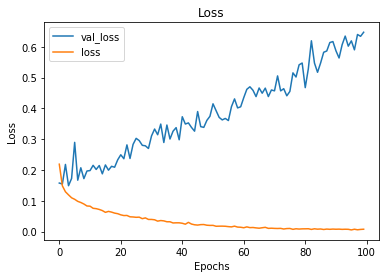

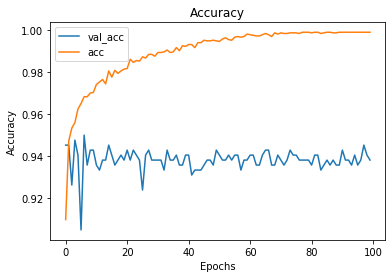

In [16]:
visualize_training_results(history)

In [17]:
saved_model = model.save('vgg19_chest_xray_ALL_data_'+str(date.today())+'_method1.h5')

In [18]:
preds_model = model.predict(test_features)

In [19]:
type(preds_model)

numpy.ndarray

In [20]:
preds_model.shape

(420, 1)

In [21]:
test_labels.shape

(420,)

In [22]:
pred_model_class = model.predict_classes(test_features)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [23]:
pred_model_class.shape

(420, 1)

In [24]:
pred_model_binary_class = (model.predict(test_features) > 0.5).astype("int32")
pred_model_binary_class.shape

(420, 1)

In [47]:
accuracy_model = accuracy_score(test_labels, preds_model.round())
accuracy_model

0.969047619047619

In [28]:
precision_model = precision_score(test_labels, preds_model.round())
precision_model

0.9865319865319865

In [29]:
recall_model = recall_score(test_labels, preds_model.round())
recall_model

0.9701986754966887

In [30]:
f1_model = f1_score(test_labels, preds_model.round())
f1_model

0.9782971619365608

In [31]:
auc_value_model = roc_auc_score(test_labels, preds_model)
auc_value_model

0.9911886855988327

In [32]:
fpr_model, tpr_model, threshold_model = roc_curve(test_labels, preds_model)

In [33]:
roc_auc_model = auc(fpr_model, tpr_model)

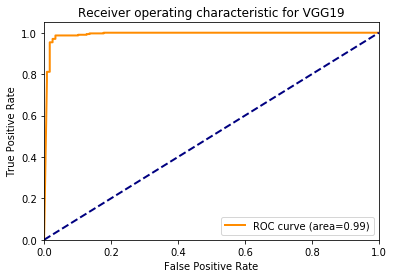

In [34]:
plt.figure()
lw=2
plt.plot(fpr_model, tpr_model, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_model)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for VGG19')
plt.legend(loc='lower right')
plt.show()

In [36]:
report_model = classification_report(test_labels, preds_model.round())
print(report_model)

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       118
         1.0       0.99      0.97      0.98       302

    accuracy                           0.97       420
   macro avg       0.96      0.97      0.96       420
weighted avg       0.97      0.97      0.97       420



In [38]:
cnf_matrix_model = confusion_matrix(y_true=test_labels, y_pred=preds_model.round())
np.set_printoptions(precision=2)
print(cnf_matrix_model)

[[114   4]
 [  9 293]]


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
cm_plot_labels = ['NORMAL','PNEUMONIA']

Confusion matrix, without normalization
[[114   4]
 [  9 293]]


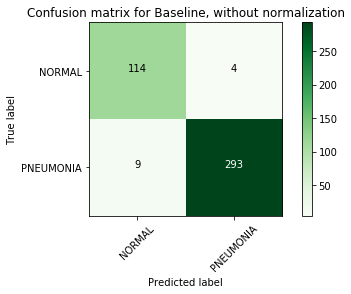

In [41]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, title='Confusion matrix for Baseline, without normalization')
plt.show()

Normalized confusion matrix
[[0.97 0.03]
 [0.03 0.97]]


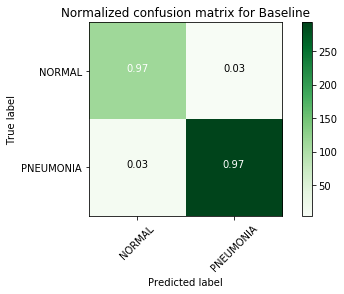

In [42]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

In [43]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'vgg19_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)